In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#Load in the data
setwd("../data")
lm.pval.df.22q1 = read.table("chronos_22q1_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)
lm.pval.df.22q2 = read.table("chronos_22q2_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

In [3]:
#Collect the minimum fdr for each gene and for each dataset
min.fdr.22q1 = lm.pval.df.22q1 %>%
rowwise() %>%
mutate("min_fdr_22q1" = min(across(afr_fdr:sas_fdr))) %>%
select(gene, min_fdr_22q1)

min.fdr.22q2 = lm.pval.df.22q2 %>%
rowwise() %>%
mutate("min_fdr_22q2" = min(across(afr_fdr:sas_fdr))) %>%
select(gene, min_fdr_22q2)

#Bind the two datasets together
min.fdr.both.datasets.df = inner_join(min.fdr.22q1, min.fdr.22q2, by = "gene")

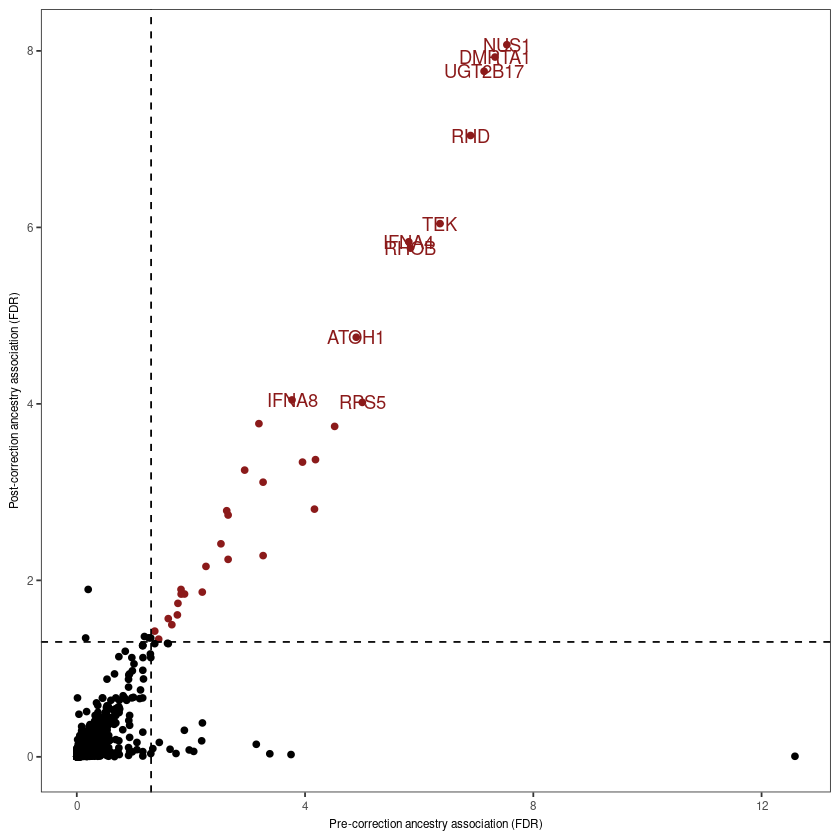

In [4]:
#Plot the scatterplot
scatterplot.df = min.fdr.both.datasets.df %>%
mutate("sig_flag" = ifelse(min_fdr_22q1 < 0.05 & min_fdr_22q2 < 0.05, TRUE, FALSE)) 

scatterplot.df %>%
ggplot(aes(x = -log10(min_fdr_22q1), y = -log10(min_fdr_22q2), color = sig_flag)) +
geom_point() +

scale_color_manual(values = c("black", "firebrick4")) +

geom_hline(yintercept = 1.302, linetype = 2) +
geom_vline(xintercept = 1.302, linetype = 2) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
legend.position = "none"
) +

ylab("Post-correction ancestry association (FDR)") +
xlab("Pre-correction ancestry association (FDR)") +

geom_text(
data = filter(scatterplot.df, min_fdr_22q2 < 0.0001), aes(label = gene)
)

#Export it to the google bucket
setwd('../output')
ggsave("figure_4e.pdf", width = 3, height = 3)

In [5]:
#Calculate the number of significant genes

sig.in.22q1 = scatterplot.df %>% filter(min_fdr_22q1 < 0.05)
sig.in.22q2 = scatterplot.df %>% filter(min_fdr_22q2 < 0.05)
sig.in.22q1.not.22q2 = scatterplot.df %>% filter(min_fdr_22q1 < 0.05 & min_fdr_22q2 > 0.05)
sig.in.22q2.not.22q1 = scatterplot.df %>% filter(min_fdr_22q1 > 0.05 & min_fdr_22q2 < 0.05)
sig.in.22q1.and.22q2 = scatterplot.df %>% filter(min_fdr_22q1 < 0.05 & min_fdr_22q2 < 0.05)

sig.in.22q1 %>% nrow()
sig.in.22q2 %>% nrow()
sig.in.22q1.not.22q2 %>% nrow()
sig.in.22q2.not.22q1 %>% nrow()
sig.in.22q1.and.22q2 %>% nrow()

[1] 49

[1] 38

[1] 16

[1] 5

[1] 33

In [6]:
#Write the dataset that was used for making this plot
setwd("../output")
write.table(scatterplot.df, "figure_4e_scatterplot_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)